In [ ]:
# coding = utf-8
import numpy as np
import torch
import torch.optim as optim
import pandas as pd
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['xtick.labelsize'] = 10    
plt.rcParams['ytick.labelsize'] = 10    
plt.rcParams['axes.titlesize'] = 17     
plt.rcParams['axes.labelsize'] = 16    
plt.rcParams['axes.linewidth'] = 1      

torch.manual_seed(1234)

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available")
else:
    device = torch.device('cpu')

GPU is available


odict_keys(['layers.layer_0.weight', 'layers.layer_0.bias', 'layers.layer_1.weight', 'layers.layer_1.bias', 'layers.layer_2.weight', 'layers.layer_2.bias', 'layers.layer_3.weight', 'layers.layer_3.bias'])


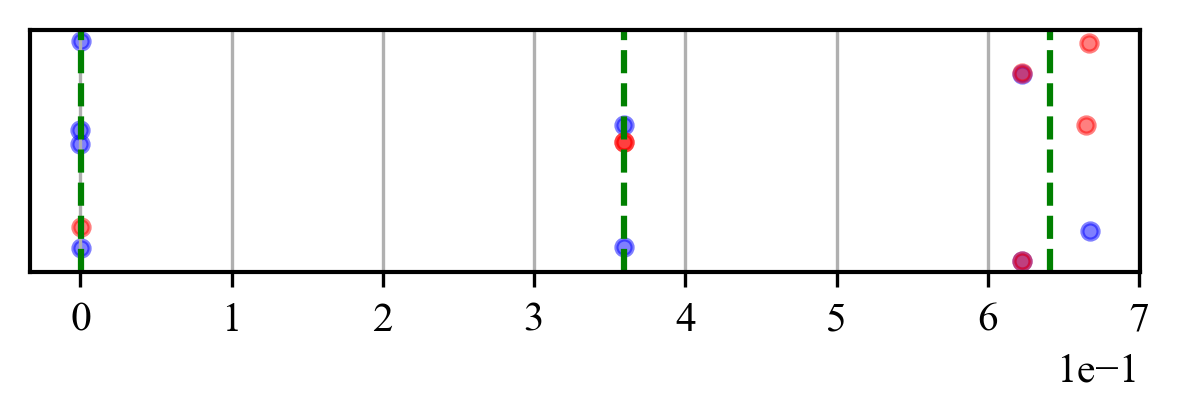

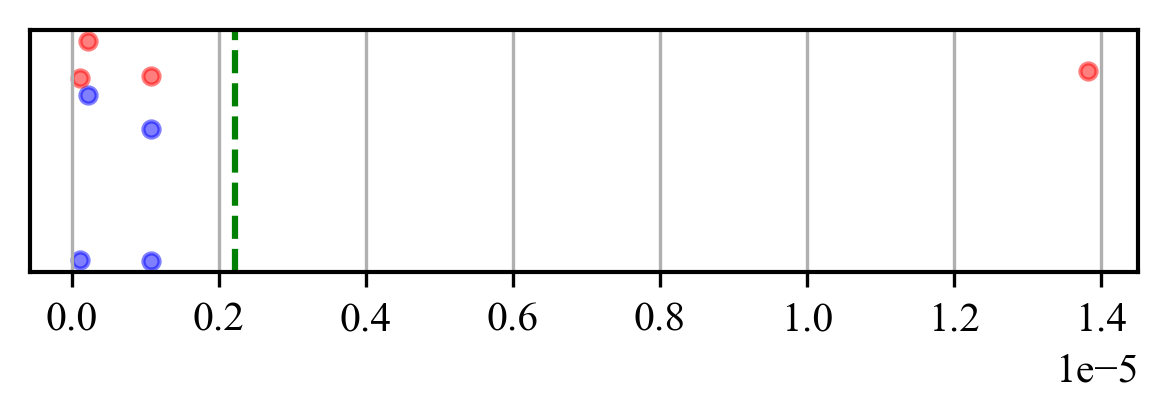

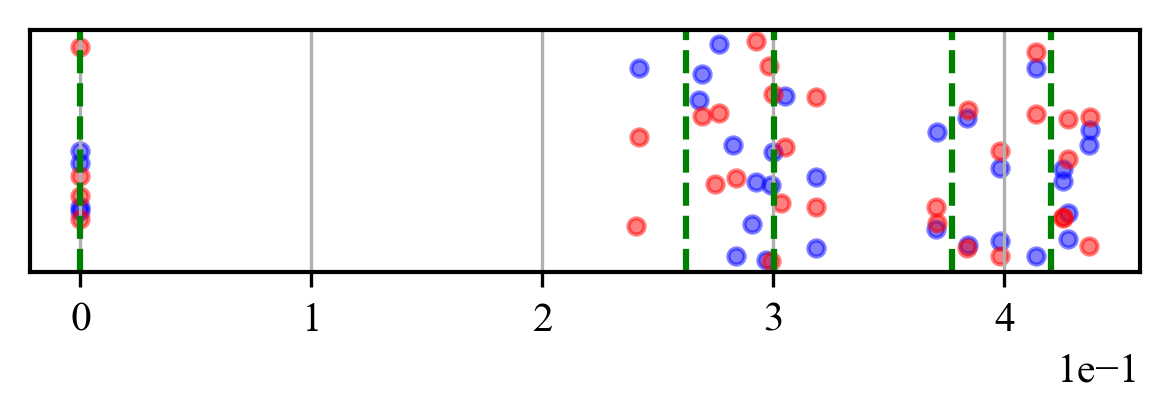

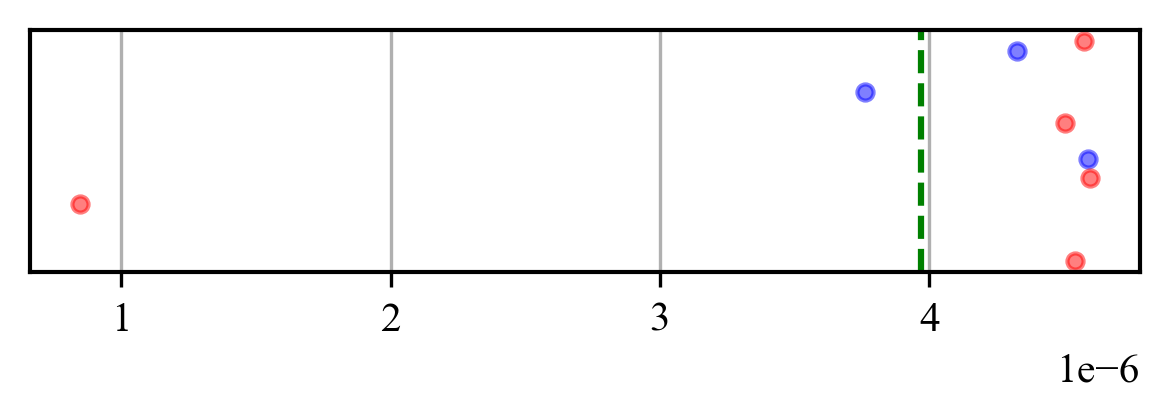

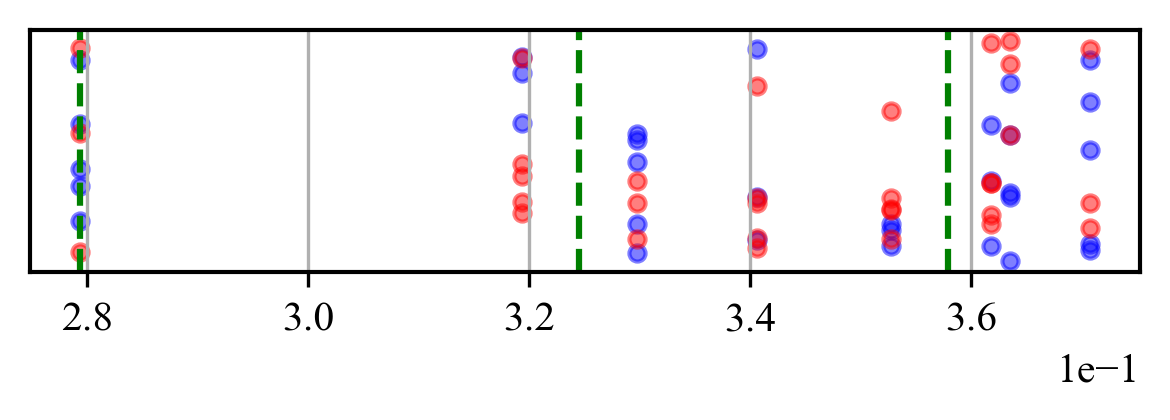

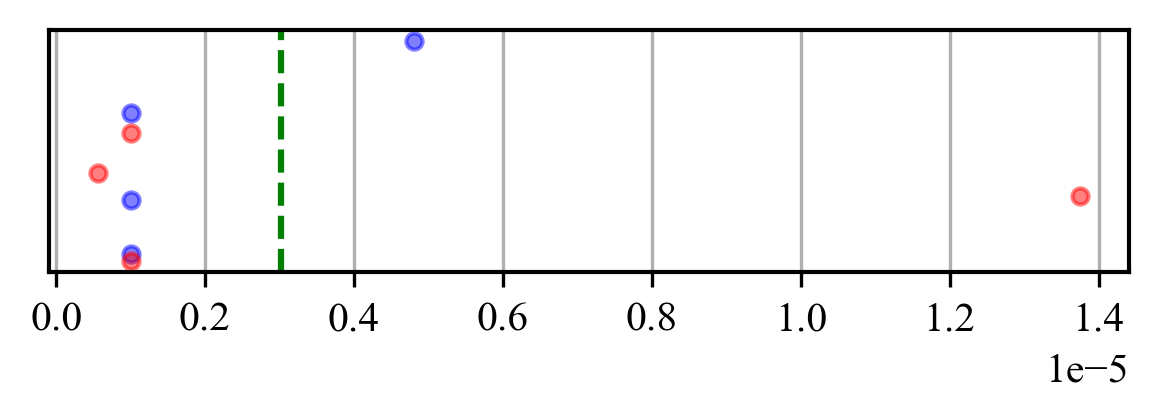

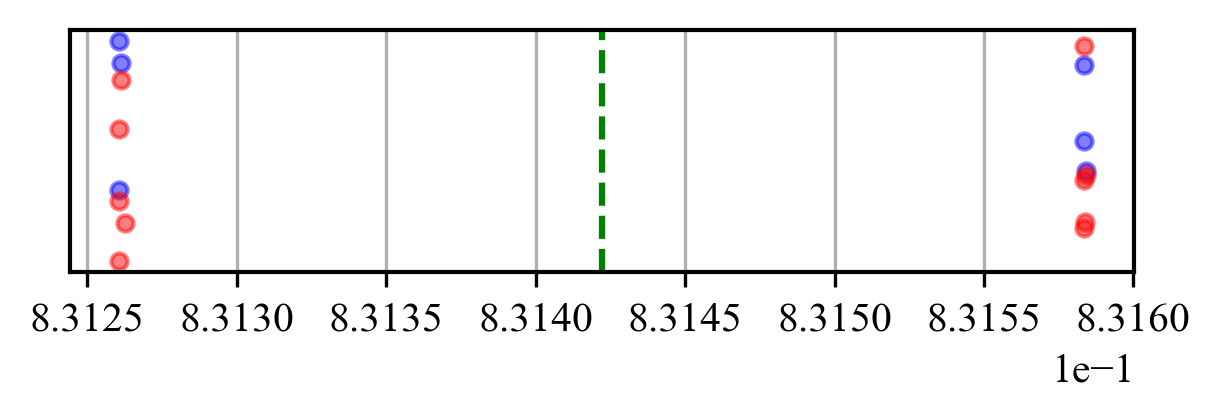

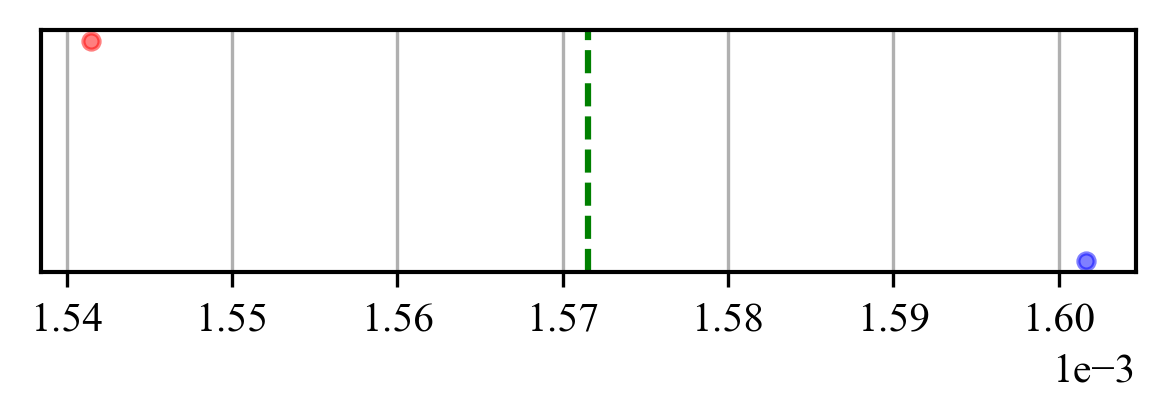

In [ ]:
# 加载.pth 文件并聚类绘图
# Load .pth file and perform clustering

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

ques_name = 'Laplace_distill'
ini_num = 1
model_name = 'PINN'

mode = 'student'

if mode == 'student':
    model_name += '_student'


###### replace it to where your .pth file is located #########
file_path = f"./Results/{ques_name}_{ini_num}/Models/{ques_name}_{ini_num}_{model_name}_step_100000.pth" 



named_params = torch.load(file_path)
print(named_params.keys())

for name, param in named_params.items():
    layer_weights = param.detach().cpu().numpy().flatten()

    # 将所有的负值转化为正值，并标识为红色
    # replace negative values with positive ones and mark them in red
    positive_weights = layer_weights[layer_weights >= 0]
    negative_weights = -layer_weights[layer_weights < 0]  # 转化为正值

    # 为了更好地辨别，将点沿着y轴方向稍微分开
    # To better distinguish, slightly separate the points along the y-axis
    y_positive = np.random.uniform(-0.1, 0.1, size=len(positive_weights))
    y_negative = np.random.uniform(-0.1, 0.1, size=len(negative_weights))


    # 计算权重的绝对值
    # Compute the absolute value of the weights
    abs_weights = np.abs(layer_weights).reshape(-1, 1)

    if len(abs_weights) < 2:
        cluster_centers = [abs_weights.mean()]
    else:
        Z = linkage(abs_weights, method='ward')
        max_distance = 0.1  
        labels = fcluster(Z, max_distance, criterion='distance')

        cluster_centers = []
        for label in np.unique(labels):
            cluster_center = abs_weights[labels == label].mean()
            cluster_centers.append(cluster_center)

    plt.figure(figsize=(4, 1.5))
    dot_size = 15
    plt.scatter(positive_weights, y_positive, color='blue', alpha=0.5, s=dot_size, label=f'Positive {name}')
    plt.scatter(negative_weights, y_negative, color='red', alpha=0.5, s=dot_size, label=f'Negative {name} (converted to positive)')
    
    for i, center in enumerate(cluster_centers):
        plt.axvline(x=center, color='green', linestyle='--', label='Cluster Center' if i == 0 else "")

    plt.yticks([])
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    plt.grid()
    plt.tight_layout()  

    if not os.path.exists(f"./Results/{ques_name}_{ini_num}/Cluster"):
        os.makedirs(f"./Results/{ques_name}_{ini_num}/Cluster")
    
    plt.savefig(f'./Results/{ques_name}_{ini_num}/Cluster/{ques_name}_{ini_num}_{name}_distribution.png', dpi = 300)

    plt.show()

    
    plt.close()

In [ ]:
# 给出所有的参数
# all parameters
for name, param in named_params.items():
    print(name, '\n', param.data)

fc1.weight 
 tensor([[-0.6394,  0.0548],
        [-0.6394,  0.0548],
        [-0.6298,  0.6367],
        [-0.2215,  0.1633],
        [ 0.0850, -0.6738],
        [ 0.8823,  0.8748],
        [-0.0837,  0.6755],
        [-0.6295,  0.6355]], device='cuda:0')
fc1.bias 
 tensor([ 4.2951e-05,  4.3031e-05, -1.0606e+00,  9.1959e-04, -2.5185e-01,
         1.6353e-04, -2.4857e-01,  1.0596e+00], device='cuda:0')
fc2.weight 
 tensor([[-0.2445, -0.2445, -0.0390, -0.0160, -0.2467, -0.8409,  0.2356,  0.0267],
        [-0.3061, -0.3061,  0.8248, -0.2316,  0.6704,  0.0398,  0.0490, -1.9413],
        [-0.2617, -0.2617,  0.0081, -0.0178, -0.2545, -0.8552,  0.2625, -0.0208],
        [ 0.3062,  0.3062,  1.9435,  0.2297,  0.0529, -0.0396,  0.6670, -0.8230],
        [-0.3307, -0.3306, -0.2688, -0.2268,  0.3464, -0.0072, -0.3462, -0.2674],
        [-0.5215, -0.5215, -0.3544, -0.1680, -0.1089,  0.5640,  0.1099, -0.3544],
        [-0.2530, -0.2530,  0.0117, -0.0169, -0.2450, -0.8461,  0.2544, -0.0241],
        [

In [ ]:
# 结构识别
# structure distinguish
import string
from scipy.cluster.hierarchy import linkage, fcluster
for name, param in named_params.items():
    # 提取该层的权重
    layer_weights = param.detach().cpu().numpy()
    flattened_weights = layer_weights.flatten()

    # 计算权重的绝对值
    abs_weights = np.abs(flattened_weights).reshape(-1, 1)

    # 检查权重数量是否少于两个
    if len(abs_weights) < 2:
        cluster_centers = [abs_weights.mean()]
        labels = np.zeros_like(flattened_weights, dtype=int)
    else:
        # 使用层次聚类对权重进行分类
        Z = linkage(abs_weights, method='ward')
        max_distance = 0.1  # 设置最大距离阈值
        labels = fcluster(Z, max_distance, criterion='distance')

        # 计算每个聚类的中心
        cluster_centers = []
        for label in np.unique(labels):
            cluster_center = abs_weights[labels == label].mean()
            cluster_centers.append(cluster_center)

    # 检查 cluster_centers 是否为空
    if len(cluster_centers) == 0:
        print(f"Layer {name} has no valid clusters.")
        continue

    # 使用字母代号标识聚类中心
    cluster_labels = {i + 1: letter for i, letter in enumerate(string.ascii_uppercase[:len(cluster_centers)])}
    cluster_mapping = {letter: center for letter, center in zip(cluster_labels.values(), cluster_centers)}

    # 替换权重为聚类中心，同时保留原始符号
    clustered_weights = np.array([
        cluster_centers[label - 1] * np.sign(weight) if label - 1 < len(cluster_centers) else 0
        for label, weight in zip(labels, flattened_weights)
    ])
    clustered_weights = clustered_weights.reshape(layer_weights.shape)

    # 生成符号化的字母代号矩阵
    symbolized_weights = np.array([
        f"{'-' if weight < 0 else ''}{cluster_labels[label]}"
        if label in cluster_labels else "0"
        for weight, label in zip(flattened_weights, labels)
    ])
    symbolized_weights = symbolized_weights.reshape(layer_weights.shape)

    # 将替换后的权重分层输出为字母代号矩阵形式
    print(f"Layer: {name}")
    print("Symbolized Weights Matrix:")
    print(symbolized_weights)

    # 输出聚类中心的字母代号映射
    print("Cluster Mapping (Letter -> Center):")
    for letter, center in cluster_mapping.items():
        print(f"{letter}: {center}")


Layer: fc1.weight
Symbolized Weights Matrix:
[['-A' 'B']
 ['-A' 'B']
 ['-A' 'B']
 ['-A' 'B']
 ['-B' '-A']
 ['A' '-B']
 ['B' 'A']
 ['B' 'A']
 ['-B' 'A']
 ['-B' 'A']
 ['-B' '-A']
 ['B' 'A']
 ['A' '-B']
 ['-A' '-B']
 ['-B' '-A']
 ['-B' '-A']]
Cluster Mapping (Letter -> Center):
A: 1.225144624710083
B: 0.043349750339984894
Layer: fc1.bias
Symbolized Weights Matrix:
['A' 'A' 'A' 'A' 'A' '-A' '-A' '-A' '-A' '-A' 'A' '-A' '-A' 'A' 'A' 'A']
Cluster Mapping (Letter -> Center):
A: 0.012397093698382378
Layer: fc2.weight
Symbolized Weights Matrix:
[['F' 'F' 'F' 'F' '-H' '-F' 'H' 'H' 'H' 'H' '-H' 'H' '-F' 'F' '-H' '-H']
 ['G' 'G' 'G' 'G' 'I' '-G' '-I' '-I' 'I' 'I' 'I' '-I' '-G' 'G' 'I' '-I']
 ['K' 'K' 'K' 'K' 'H' '-K' '-H' '-H' '-H' '-H' 'H' '-H' '-K' 'K' 'H' 'H']
 ['-K' '-K' '-K' '-K' '-H' 'K' 'H' 'H' 'H' 'H' '-H' 'H' 'K' '-K' '-H'
  '-H']
 ['H' 'H' 'H' 'H' 'J' '-H' '-J' '-J' '-J' '-J' 'J' '-J' '-H' 'H' 'J' 'J']
 ['A' 'A' 'A' 'A' 'F' '-A' '-F' '-F' '-E' '-E' 'F' '-F' '-A' 'A' 'F' 'F']
 ['-K' '-K' 